In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

In [2]:
oct19= pd.read_csv('s3://sapienza2020adm/ecommerce/2019-Oct.csv',
                      parse_dates=['event_time'],
                      date_parser=pd.to_datetime,nrows=40000)
nov19=pd.read_csv('s3://sapienza2020adm/ecommerce/2019-Nov.csv',
                      parse_dates=['event_time'],
                      date_parser=pd.to_datetime,nrows=40000)

In [3]:
frame = [oct19,nov19]
df = pd.concat(frame)

In [4]:
print(df.shape)
df.head(5)

(80000, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [5]:
df.tail(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
39995,2019-11-01 02:31:08+00:00,view,7300489,2053013552863641845,NaN,transcend,80.56,552026815,f743825e-6c13-4514-b703-447e22dced73
39996,2019-11-01 02:31:08+00:00,view,4804295,2053013554658804075,electronics.audio.headphone,xiaomi,22.80,558730130,8c8eeeb6-2505-469f-bcec-b4e7733673df
39997,2019-11-01 02:31:09+00:00,view,5700788,2053013553970938175,auto.accessories.player,kenwood,85.86,553856707,69422120-2336-41d4-8a45-da575326cc0f
39998,2019-11-01 02:31:09+00:00,view,34800581,2062461754293617058,NaN,carfashion,28.31,563990930,b99b703d-1132-4436-ba13-6aa8e2b4f089
39999,2019-11-01 02:31:09+00:00,view,1201390,2053013561059312345,electronics.tablet,apple,1883.05,552586585,115e8b62-b14b-4d37-9c0a-24985e77de6a


## Q1 Suppose your funnel involves just three simple steps: 1) view, 2) cart, 3) purchase. Which is the rate of complete funnels?

In [6]:
CF = df.groupby(['product_id','user_session','event_type']).event_type.count()
#rename()-> Alter axes labels.
#reset_index()->Reset the index of the DataFrame, and use the default one instead. 
CF = pd.DataFrame(CF).rename(columns={'event_type':'count'}).reset_index()
gc.collect()
CF = CF.groupby(['product_id','user_session']).user_session.count()
CF = pd.DataFrame(CF).rename(columns={'user_session':'count'}).reset_index()
gc.collect()
Total=int(CF.shape[0])
Th = CF[CF['count']==3].shape[0]
CFR = round(Th*100 / Total,2)
print("The rate of complete funnels is "+str(CFR)+'%.')


The rate of complete funnels is 0.51%.


### Q1-1 What’s the operation users repeat more on average within a session? Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).

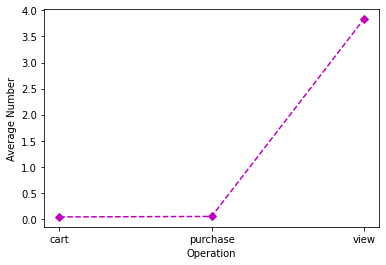

1)  The most common operation:view
2)  The average number of view operation:3.83
3)  The average number of purchase operation:0.05
4)  The average number of cart operation:0.04
5)  The average number of removefromcart operation:0


In [7]:
'''
Calculate all the times of diffenrent operations AP
'''
AP = df.groupby('event_type').event_type.count()
#print(AP)
# nunique()-> Return number of unique elements in the object.
# unique()-> Return the value of unique elements in the object.
'''
Calculate the average number of times users perform each operation AVAP
'''
AVAP = AP.to_numpy() / df.user_session.nunique()
#print(df.user_session.nunique())
'''
Sort the event_type by the number of  different operations ET
'''
ET = sorted(df.event_type.unique())
plt.xlabel('Operation')
plt.ylabel('Average Number')
plt.plot(ET, AVAP, color='m', linestyle='dashed',  marker='D')
plt.show()

print("1)  The most common operation:"+str(ET[-1]))
print("2)  The average number of view operation:"+str(round(AVAP[2],2)))
print("3)  The average number of purchase operation:"+str(round(AVAP[1],2)))
print("4)  The average number of cart operation:"+str(round(AVAP[0],2)))
print("5)  The average number of removefromcart operation:"+str(0))

### Q1-2 How many times, on average, a user views a product before adding it to the cart?

In [8]:

VCT= pd.DataFrame(df[(df.event_type == 'view') | (df.event_type == 'cart')].groupby(['product_id','user_session', 'event_type']).event_type.count()).rename(columns={'event_type':'my_count'}).reset_index()

VC = pd.DataFrame(VCT.groupby(['product_id','user_session']).user_session.count()).rename(columns={'user_session':'count'}).reset_index()
VC = VC[VC['count'] == 2]

VC = pd.merge(VCT,VC[['product_id','user_session']], how='inner', on=['product_id','user_session'])

MT= VCT[VCT['event_type'] == 'view'].my_count.mean()

print("The average times that users view a product before purchase it is "+str(round(MT,2)))


The average times that users view a product before purchase it is 1.43


### Q1-3 What’s the probability that products added once to the cart are effectively bought?

Let a={product is added once to the cart},b={product is purchased},then P(products added once to the cart are effectively bought)=P(b|a).
From the multiplication rule, we can know that P(ab)= P(b|a) * P(a), so P(b|a) = P(ab)/P(a).

In [9]:
P_a=df[df['event_type']=='cart'].shape[0]
#Sum = df.user_session.nunique()
CP = pd.DataFrame(df[(df.event_type == 'cart') | (df.event_type == 'purchase')].groupby(['product_id','user_session', 'event_type']).event_type.count()).rename(columns={'event_type':'my_count'}).reset_index()
CP = pd.DataFrame(CP.groupby(['product_id','user_session']).user_session.count()).rename(columns={'user_session':'count'}).reset_index()
CP = CP[CP['count']==2]
P_ab= CP.shape[0]
#P_ab = (Pa * P_b_a) / pow(Sum,2)
P_ba = round(P_ab / P_a,2) 
print("The probability that products added once to the cart are effectively bought is " + str(P_ba))

The probability that products added once to the cart are effectively bought is 0.35


### Q1-4 What’s the average time an item stays in the cart before being removed?

Because we do not find any removerfromcart operation in the file, we think that goods are removed from the cart means that they are purchased successfully.
The average time an item stays in the cart before being removed can be transform to the average time an item stays in the cart before purchased.

In [10]:
cart = df[df['event_type'] == 'cart'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
remove = df[df['event_type'] == 'purchase'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
joint = pd.merge(cart, remove[['user_session','event_time']], how='inner', on=['user_session']).dropna()
mean_time = (joint.event_time_y - joint.event_time_x).mean()
cart_remove_time = pd.Timedelta(mean_time).total_seconds() 
print("The average time an item stays in the cart before being removed is " +str(round(cart_remove_time,2))+ ' seconds.')

The average time an item stays in the cart before being removed is 109.57 seconds.


### Q1-5 How much time passes on average between the first view time and a purchase/addition to cart?

In [11]:
view = df[df['event_type'] == 'view'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
cart = df[df['event_type'] == 'cart'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
joint = pd.merge(view, cart[['user_session','event_time']], how='inner', on=['user_session']).dropna()
mean_time = (joint.event_time_y - joint.event_time_x).mean()
view_cart_time = pd.Timedelta(mean_time).total_seconds()
print("The average time between the first view and add to cart is " +str(round(view_cart_time,2))+ ' seconds.')

The average time between the first view and add to cart is 171.93 seconds.


In [12]:
view = df[df['event_type'] == 'view'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
purchase = df[df['event_type'] == 'purchase'].sort_values(by=['event_time']).drop_duplicates(subset = ['user_session'], keep = 'first') 
joint = pd.merge(view, purchase[['user_session','event_time']], how='inner', on=['user_session']).dropna()
mean_time = (joint.event_time_y - joint.event_time_x).mean()
view_purchase_time = pd.Timedelta(mean_time).total_seconds()
print("The average time between the first view and a purchase is " +str(round(view_purchase_time,2))+ ' seconds.')

The average time between the first view and a purchase is 260.09 seconds.


## Q7 Prove that the pareto principle applies to your store.

The Pareto principle states that for many outcomes roughly 80% of consequences come from 20% of the causes. Also known as 80/20 rule, in e-commerce simply means that most of your business, around 80%, likely comes from about 20% of your customers.

In [13]:
business = df[df['event_type'] == 'purchase'].event_type.count()
customers = df[df['event_type'] == 'purchase'].user_id.nunique()
#all_customers = df.user_id.nunique()

BC= pd.DataFrame(df[df.event_type == 'purchase'].groupby(['product_id','event_type','user_id']).user_id.count()).rename(columns={'user_id':'my_count'}).reset_index().groupby('my_count').my_count.count()
print(BC)
print("Business numbers:"+str(business*0.8))
print("Customers who purchased:"+str(customers*0.2))


my_count
1     843
2      37
3       8
5       1
6       1
7       1
22      1
Name: my_count, dtype: int64
Business numbers:784.8000000000001
Customers who purchased:160.8
